# Flanker task timing test plots

## Load Test 1 data

In [27]:
import pandas as pd
import numpy as np
import os
import urllib.request as urllibrequest #import urllib
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

def download_google_sheet(filepath, docid):
    """
    Download latest version of a Google Sheet
    Parameters
    ----------
    filepath : string
    docid : string
    Returns
    -------
    filepath : string
    """
    if not os.path.exists(os.path.abspath(os.path.dirname(filepath))):
        os.makedirs(os.path.abspath(os.path.dirname(filepath)))
    urllibrequest.urlretrieve("{1}{0}{2}".format(
        docid,
        'https://docs.google.com/spreadsheets/d/',
        '/export?format=csv'
        ), filepath)
    return filepath

# MindLogger exported Flanker csv table with test data:
# Google sheet format: Format -> Number -> Custom number format: 0.0000
## block_number	trial_number	trial_type	event_type	frame	experiment_start_timestamp	block_start_timestamp	trial_start_timestamp	event_start_timestamp	video_display_request_timestamp	response_touch_timestamp	trial_offset	event_offset	response_time	response	response_accuracy
## 1.0000	8.0000	>>>>>	Fixation	339.0000	1657918589.9240	1657918888.0330	1657918895.0680	1657918895.0680	1657918895.0400	.	7.0360	0.0000	.	.	.											
base_dir = '/Users/arno/Software/mindlogger-time-tests/'
google_sheet = '1nhoswgFJnv4I3YOskfErXW4XQFGiWMSL87UAjl3zQ4M' # 62d1d6cc154fa87efa129b85
csv_file = base_dir + 'input/flanker_test_20220715/flanker_test1_excerpt.csv'
columns = ['block_number','trial_number','trial_type','event_type','frame_touch','frame_remove','experiment_start_timestamp',
           'block_start_timestamp','trial_start_timestamp','event_start_timestamp',
           'video_display_request_timestamp','response_touch_timestamp','trial_offset','event_offset',
           'response_time','response','response_accuracy']

In [35]:
data_table = download_google_sheet(csv_file, google_sheet)

df = pd.read_csv(csv_file, usecols=columns)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Movie of the Flanker task test 1 block of trials:
# Convert movie and add frame numbers:
## ffmpeg -i /Users/arno.klein/Downloads/flanker-test-20220715.mp4 -vf "drawtext=fontfile=Arial.ttf: text='%{frame_num}': fontsize=200: start_number=1: x=(w-tw)/2: y=h-(2*lh): fontcolor=black: fontsize=20: box=1: boxcolor=white: boxborderw=5" -c:a copy /Users/arno/Downloads/flanker_test_20220715_frames.mp4
fps = 240
ms_per_frame = 1000/fps

# Excel table with test data frame numbers:
#frames = df.frame_touch
frames = (df.frame_touch + df.frame_remove)/2
frame_times = np.array([x * 1000 / fps for x in frames])
imax = len(frames)

## Touch to fixation

  - Define touch to fixation in the movie as the time between contact with the screen and first appearance of the fixation.
  - Define touch to fixation in the data export as the time between recorded response_touch_timestamp and recorded event_start_timestamp representing the next fixation event. 

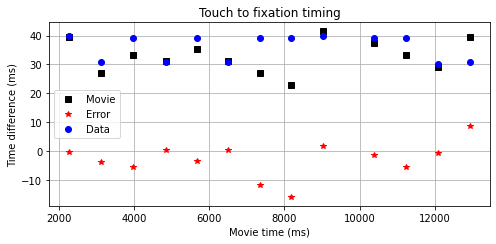

Touch to fixation time:
Movie mean (SD): 33.01 (5.41) +- 8.33 ms (2 frames)
Data mean (SD): 36.00 (4.13) ms
Error (movie - data) mean (SD): -2.99 (5.93)


In [36]:
touch_to_fixation_movie = pd.Series(np.zeros(len(frames)))
fixation_to_stimulus_movie = pd.Series(np.zeros(len(frames)))
i = 0
for frame in frames:
    i = i + 1
    if i > 1:
        if i % 3 == 1:
            touch_to_fixation_movie[i-1] = (frame - frames[i-2]) * 1000 / fps
        else:
            touch_to_fixation_movie[i-1] = np.nan
        if i % 3 == 2:
            fixation_to_stimulus_movie[i-1] = (frame - frames[i-2]) * 1000 / fps
        else:
            fixation_to_stimulus_movie[i-1] = np.nan
            
touch_to_fixation = pd.Series(np.zeros(len(frames)))
i = 0
for frame in frames:
    i = i + 1
    if i > 1:
        if i % 3 == 1:
            touch_to_fixation[i-1] = 1000 * (float(df.event_start_timestamp[i-1]) - float(df.response_touch_timestamp[i-2]))
        else:
            touch_to_fixation[i-1] = np.nan

touch_to_fixation_error = touch_to_fixation_movie - touch_to_fixation

imin = 1

plt.plot(frame_times[imin:imax], touch_to_fixation_movie[imin:imax], marker='s', linestyle='', color='k', label='Movie')
plt.plot(frame_times[imin:imax], touch_to_fixation_error[imin:imax], marker='*', linestyle='', color='r', label='Error')
plt.plot(frame_times[imin:imax], touch_to_fixation[imin:imax], marker='o', linestyle='', color='b', label='Data')
plt.title('Touch to fixation timing')
plt.xlabel ('Movie time (ms)')
plt.ylabel ('Time difference (ms)')
plt.legend()
plt.grid()
plt.show()

print("Touch to fixation time:")
print("Movie mean (SD): {0:.2f} ({1:.2f}) +- {2:.2f} ms (2 frames)".format(np.mean(touch_to_fixation_movie[imin:imax]),
                                                                           np.std(touch_to_fixation_movie[imin:imax]),
                                                                           2 * ms_per_frame))
print("Data mean (SD): {0:.2f} ({1:.2f}) ms".format(np.mean(touch_to_fixation[imin:imax]), 
                                                           np.std(touch_to_fixation[imin:imax])))
print("Error (movie - data) mean (SD): {0:.2f} ({1:.2f})".format(np.mean(touch_to_fixation_error[imin:imax]), 
                                                                   np.std(touch_to_fixation_error[imin:imax])))
